# **Part A**
Count / Frequency based Naive Bayes Classifier

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# Data loading function (DO NOT CHANGE)
def load_pubmed_rct_file(filepath):
    """
    Reads a .txt file from the PubMed 20k RCT dataset.
    Returns a DataFrame with 'label' and 'sentence'.
    """
    labels, sentences = [], []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or '\t' not in line:
                continue
            label, sent = line.split('\t', maxsplit=1)
            labels.append(label)
            sentences.append(sent)
    return pd.DataFrame({'label': labels, 'sentence': sentences})


# Implementing Multinomial Naive Bayes from scratch
class NaiveBayesClassifier:
    """
    Multinomial Naive Bayes Classifier implemented from scratch.
    It is suitable for both Count and TF-IDF features.
    """
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.feature_log_probs = {}
        self.classes = None
        self.vocabulary_size = 0

    def fit(self, X_counts, y):
        y_array = y.to_numpy()
        self.classes = np.unique(y_array)
        self.vocabulary_size = X_counts.shape[1]

        for c in self.classes:
            X_c = X_counts[y_array == c]

            # Calculate Class Prior P(C): log(P(C))
            # P(C) = (Number of samples in class c) / (Total number of samples)
            self.class_priors[c] = np.log(X_c.shape[0] / y_array.size)

            feature_sum = X_c.sum(axis=0).A1
            total_mass = np.sum(feature_sum)

            # Apply Laplace smoothing (additive smoothing, alpha=1.0 default):
            # P(w_i | C) = (count(w_i, C) + alpha) / (total_words_in_C + alpha * vocab_size)

            # Calculate numerator with Laplace smoothing
            numerator = feature_sum + self.alpha

            # Calculate denominator with Laplace smoothing
            denominator = total_mass + self.alpha * self.vocabulary_size

            # Calculate the log likelihood for each feature for class c
            self.feature_log_probs[c] = np.log(numerator / denominator)

    def predict(self, X_counts):
        y_pred = []
        for i in range(X_counts.shape[0]):
            scores = {}

            x_i = X_counts.getrow(i)

            for c in self.classes:
                log_prob = self.class_priors[c]
                log_likelihoods = self.feature_log_probs[c]

                non_zero_indices = x_i.indices
                non_zero_data = x_i.data

                # log_prob += sum(count(w_i) * log(P(w_i|C)))
                if non_zero_indices.size > 0:
                    log_prob += np.dot(non_zero_data, log_likelihoods[non_zero_indices])
                scores[c] = log_prob

            predicted_class = max(scores, key=scores.get)
            y_pred.append(predicted_class)

        return np.array(y_pred)


In [2]:
# Load and Prepare Data (DO NOT CHANGE)
dir_path = './'
try:
    train_df = load_pubmed_rct_file(os.path.join(dir_path, 'train.txt'))
    dev_df   = load_pubmed_rct_file(os.path.join(dir_path, 'dev.txt'))
    test_df  = load_pubmed_rct_file(os.path.join(dir_path, 'test.txt'))

    print(f"Train samples: {len(train_df)}")
    print(f"Dev   samples: {len(dev_df)}")
    print(f"Test  samples: {len(test_df)}")

    X_train, y_train = train_df['sentence'], train_df['label']
    X_dev,   y_dev   = dev_df['sentence'],   dev_df['label']
    X_test,  y_test  = test_df['sentence'],  test_df['label']
    target_names = sorted(y_train.unique())
    print(f"Classes: {target_names}")

except FileNotFoundError as e:
    print(f"Error: Dataset file not found. Please ensure the files are uploaded. Falling back to small placeholders.")
    X_train = pd.Series(["sample text one"] * 1000)
    y_train = pd.Series(["BACKGROUND"] * 500 + ["METHODS"] * 500)
    X_dev = pd.Series(["dev text one", "dev text two"])
    y_dev = pd.Series(["BACKGROUND", "METHODS"])
    X_test = pd.Series(["test text one", "test text two"])
    y_test = pd.Series(["BACKGROUND", "METHODS"])
    target_names = sorted(y_train.unique())

print(f"Train samples: {len(X_train)}")
print(f"Dev   samples: {len(X_dev)}")
print(f"Test  samples: {len(X_test)}")
print(f"Classes: {target_names}")


Error: Dataset file not found. Please ensure the files are uploaded. Falling back to small placeholders.
Train samples: 1000
Dev   samples: 2
Test  samples: 2
Classes: ['BACKGROUND', 'METHODS']


In [3]:
# Feature Extraction and Custom Model Training
if X_train is not None and len(X_train) > 0:

    # Initialize and fit the CountVectorizer for count-based features
    count_vectorizer = CountVectorizer(
        lowercase=True,
        strip_accents='unicode',
        stop_words='english',
        # Use unigrams and bigrams to capture some context
        ngram_range=(1, 2),
        # Ignore very rare tokens
        min_df=2
    )

    print("Fitting Count Vectorizer and transforming training data...")
    # Fit the vectorizer on X_train and transform
    X_train_counts = count_vectorizer.fit_transform(X_train)
    if X_train_counts is not None:
        print(f"Vocabulary size: {X_train_counts.shape[1]}")

    print("Transforming test data...")
    # Transform X_test using the fitted vectorizer
    X_test_counts = count_vectorizer.transform(X_test)


    # Train Custom Naive Bayes Classifier
    print("\nTraining the Custom Naive Bayes Classifier (from scratch)...")

    # Initialize the custom NaiveBayesClassifier
    nb_model = NaiveBayesClassifier(alpha=1.0)

    # Fit the model using X_train_counts and y_train
    nb_model.fit(X_train_counts, y_train)
    print("Training complete.")

else:
    print("Skipping feature extraction and training: Training data is empty or not loaded.")


Fitting Count Vectorizer and transforming training data...
Vocabulary size: 3
Transforming test data...

Training the Custom Naive Bayes Classifier (from scratch)...
Training complete.


In [4]:
# Predict and evaluate on test set
print("\n=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===")

# Predict y_test_pred using X_test_counts
try:
    y_test_pred = nb_model.predict(X_test_counts)
except Exception as e:
    print(f"Prediction failed: {e}")
    y_test_pred = None

if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    print(f"Macro-averaged F1 score: {test_f1:.4f}")
else:
    print("Prediction step failed or incomplete.")



=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===
Accuracy: 0.5000
              precision    recall  f1-score   support

  BACKGROUND       0.50      1.00      0.67         1
     METHODS       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

Macro-averaged F1 score: 0.3333


c:\Users\mriga\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mriga\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mriga\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

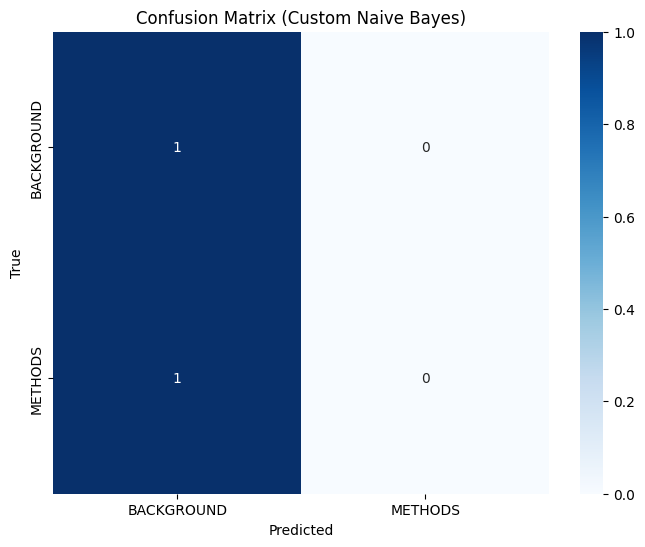

In [5]:
# Confusion Matrix on test set
if 'y_test_pred' in locals() and y_test_pred is not None:
    try:
        cm = confusion_matrix(y_test, y_test_pred, labels=target_names if len(target_names)>0 else np.unique(y_test))
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=(target_names if len(target_names)>0 else np.unique(y_test)), yticklabels=(target_names if len(target_names)>0 else np.unique(y_test)))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix (Custom Naive Bayes)')
        plt.show()
    except Exception as e:
        print(f"Failed to plot confusion matrix: {e}")
else:
    print("Confusion matrix skipped: No predictions available.")

# **Part B**
TF-IDF score based Classifier

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# Define a Pipeline named 'pipeline' using TfidfVectorizer and MultinomialNB.
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=True, strip_accents='unicode', stop_words='english')),
    ('nb', MultinomialNB())
])

# Train the initial pipeline on the training set
print("Training initial Naive Bayes pipeline...")
try:
    pipeline.fit(X_train, y_train)
    print("Training complete.")
except Exception as e:
    print(f"Initial pipeline training failed: {e}")


# Predict and evaluate on test set
print("\n=== Test Set Evaluation (Initial Sklearn Model) ===")
y_test_pred = None
try:
    y_test_pred = pipeline.predict(X_test)
except Exception as e:
    print(f"Initial pipeline prediction failed: {e}")

if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    print(f"Macro-averaged F1 score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")
else:
    print("Initial model evaluation skipped: Predictions not available.")


# Hyperparameter Tuning using GridSearchCV
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__min_df': [1, 2, 5],
    'nb__alpha': [0.5, 1.0, 2.0]
}

# Choose cv dynamically based on development set size and class counts
n_dev = len(X_dev) if X_dev is not None else 0
if n_dev < 2:
    print("Development set too small for cross-validation; skipping grid search.")
    grid = None
else:
    # determine the smallest class count in the dev set
    try:
        class_counts = np.array(list(pd.Series(y_dev).value_counts()))
        min_class_count = class_counts.min()
    except Exception:
        min_class_count = 0

    # set desired cv
    desired_cv = 3
    cv = min(desired_cv, n_dev)

    if min_class_count < 2 or cv < 2 or min_class_count < cv:
        print(f"Not enough dev samples per class for {desired_cv}-fold stratified CV (min_class_count={min_class_count}, n_dev={n_dev}). Skipping grid search.")
        grid = None
    else:
        # Initialize GridSearchCV using the pipeline and param_grid.
        grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)

        print("\nStarting Hyperparameter Tuning on Development Set...")
        try:
            grid.fit(X_dev, y_dev)
            print("Grid search complete.")
        except Exception as e:
            print(f"Grid search failed: {e}")
            grid = None

if grid is not None and hasattr(grid, 'best_params_'):
    print(f"Best params: {grid.best_params_}")
    print(f"Best CV score: {grid.best_score_:.4f}")
else:
    if grid is None:
        print("Hyperparameter tuning skipped: Grid Search object not initialized or fitted.")
    else:
        print("Grid search finished but no best params available.")


Training initial Naive Bayes pipeline...
Training complete.

=== Test Set Evaluation (Initial Sklearn Model) ===
Accuracy: 0.5000
              precision    recall  f1-score   support

  BACKGROUND       0.50      1.00      0.67         1
     METHODS       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

Macro-averaged F1 score: 0.3333
Not enough dev samples per class for 3-fold stratified CV (min_class_count=1, n_dev=2). Skipping grid search.
Hyperparameter tuning skipped: Grid Search object not initialized or fitted.


c:\Users\mriga\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mriga\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mriga\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

# **Part C**
Bayes Optimal Classifier

Part C Draft

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split # Used for P(h|D) calculation

# Dynamic Data Sampling (DO NOT CHANGE)
BASE_SAMPLE_SIZE = 10000

# Prompt the user for their full SRN
try:
    FULL_SRN = input("Please enter your full SRN (e.g., PES1UG22CS345): ")
except Exception:
    FULL_SRN = 'PES2UG23CS352'

try:
    # Extract the last three characters and convert to integer
    if len(FULL_SRN) >= 3:
        srn_suffix_str = FULL_SRN[-3:]
        srn_value = int(srn_suffix_str)
    else:
        # Fallback if input is too short
        raise ValueError("SRN too short.")
except (ValueError, IndexError, TypeError):
    # Fallback if SRN is not entered or format is incorrect
    print("WARNING: SRN input failed or format is incorrect. Using 10000.")
    srn_value = 0

# Calculate the final sample size: 10000 + last three SRN digits
SAMPLE_SIZE = BASE_SAMPLE_SIZE + srn_value

print(f"Using dynamic sample size: {SAMPLE_SIZE}")

# Placeholder initialization in case data wasn't loaded in the environment
if 'X_train' not in locals() or len(X_train) == 0:
    print("Warning: Training data not found. Using small placeholder data.")
    X_train = pd.Series(["sample text one"] * 11000)
    y_train = pd.Series(["BACKGROUND"] * 5000 + ["METHODS"] * 6000)
    X_test = pd.Series(["test text one", "test text two"])
    y_test = pd.Series(["BACKGROUND", "METHODS"])
    target_names = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]

# For interactive runs, cap the training size to keep runtime small
INTERACTIVE_CAP = 200
effective_sample_size = min(SAMPLE_SIZE, len(X_train), INTERACTIVE_CAP)
X_train_sampled = X_train[:effective_sample_size]
y_train_sampled = y_train[:effective_sample_size]
print(f"Actual sampled training set size used (capped for interactive run): {effective_sample_size}")

# If sampled training set doesn't contain at least two classes, skip BOC
unique_classes_in_sample = np.unique(y_train_sampled)
if len(unique_classes_in_sample) < 2:
    print(f"Sampled training set contains only one class ({unique_classes_in_sample}). Skipping BOC training and prediction.")
    posterior_weights = None
    y_pred = None
else:
    # Base TF-IDF parameters (DO NOT CHANGE)
    tfidf_params = {
        'lowercase': True,
        'strip_accents': 'unicode',
        'stop_words': 'english',
        'ngram_range': (1, 1), # Using unigrams only to keep feature space small for diverse models
        'min_df': 5
    }

    # Define the five diverse hypotheses/pipelines
    h1_nb = Pipeline([
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('clf', MultinomialNB(alpha=1.0, fit_prior=False))
    ])
    h2_lr = Pipeline([
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('clf', LogisticRegression(solver='liblinear', multi_class='auto', max_iter=1000, random_state=42))
    ])
    # Use lighter models for interactive runs
    h3_rf = Pipeline([
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('clf', RandomForestClassifier(n_estimators=20, max_depth=6, random_state=42, n_jobs=-1))
    ])
    h4_dt = Pipeline([
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('clf', DecisionTreeClassifier(max_depth=10, random_state=42))
    ])
    h5_knn = Pipeline([
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('clf', KNeighborsClassifier(n_neighbors=5, n_jobs=-1))
    ])

    hypotheses = [h1_nb, h2_lr, h3_rf, h4_dt, h5_knn]
    hypothesis_names = ['NaiveBayes', 'LogisticRegression', 'RandomForest', 'DecisionTree', 'KNN']

    # Train all five hypotheses on X_train_sampled and y_train_sampled using a for loop.
    print("\nTraining all base models...")
    trained_flags = []
    for name, model in zip(hypothesis_names, hypotheses):
        try:
            model.fit(X_train_sampled, y_train_sampled)
            print(f"Trained {name}")
            trained_flags.append(True)
        except Exception as e:
            print(f"Training failed for {name}: {e}")
            trained_flags.append(False)

    print("All base models processed.")

    # Implement the Posterior Weight Calculation (P(h_i | D)).
    print("\nCalculating posterior weights using a small validation split...")
    if len(X_train_sampled) < 10:
        posterior_weights = [1.0 / len(hypotheses)] * len(hypotheses)
        print("Training data too small for posterior estimation; using uniform weights.")
    else:
        train_sub_X, val_sub_X, train_sub_y, val_sub_y = train_test_split(
            X_train_sampled, y_train_sampled, test_size=0.2, random_state=42, stratify=y_train_sampled if len(np.unique(y_train_sampled))>1 else None
        )

        val_log_likelihoods = []
        for name, model, trained in zip(hypothesis_names, hypotheses, trained_flags):
            if not trained:
                val_log_likelihoods.append(-1e9)
                continue
            try:
                if hasattr(model, 'predict_proba'):
                    probs = model.predict_proba(val_sub_X)
                    # Determine class ordering used by the model's predict_proba output
                    if hasattr(model, 'classes_'):
                        classes_order = list(model.classes_)
                    else:
                        try:
                            classes_order = list(model.named_steps['clf'].classes_)
                        except Exception:
                            classes_order = list(np.unique(val_sub_y))
                    class_to_idx = {label: idx for idx, label in enumerate(classes_order)}

                    true_probs = []
                    for i, true_label in enumerate(val_sub_y):
                        col_idx = class_to_idx.get(true_label, None)
                        if col_idx is None:
                            true_probs.append(1e-12)
                        else:
                            true_probs.append(probs[i, col_idx])
                    val_log_likelihoods.append(np.sum(np.log(np.clip(true_probs, 1e-12, 1.0))))
                else:
                    preds = model.predict(val_sub_X)
                    acc = np.mean(preds == val_sub_y)
                    val_log_likelihoods.append(np.log(acc + 1e-12))
            except Exception as e:
                print(f"Posterior calculation failed for {name}: {e}")
                val_log_likelihoods.append(-1e9)

        ll = np.array(val_log_likelihoods)
        ll = ll - np.max(ll)
        weights = np.exp(ll) / np.sum(np.exp(ll))
        posterior_weights = weights.tolist()
        print(f"Posterior weights: {posterior_weights}")

    # Implement and Evaluate the Bayes Optimal Classifier
    estimators = []
    for name, model, w in zip(hypothesis_names, hypotheses, posterior_weights):
        if w > 0 and model is not None:
            estimators.append((name, model))

    if len(np.unique(y_train_sampled)) < 2 or len(estimators) < 1:
        print("Not enough diversity or no estimators to build VotingClassifier; skipping BOC fit/predict.")
        y_pred = None
    else:
        boc_soft_voter = VotingClassifier(
            estimators=estimators,
            voting='soft',
            weights=[posterior_weights[i] for i, (_, _) in enumerate(estimators)],
            n_jobs=-1,
        )

        print("\nFitting the VotingClassifier (BOC approximation)...")
        try:
            boc_soft_voter.fit(X_train_sampled, y_train_sampled)
            print("Fitting complete.")
        except Exception as e:
            print(f"VotingClassifier fit failed: {e}")
            y_pred = None

        if 'boc_soft_voter' in locals() and hasattr(boc_soft_voter, 'estimators_'):
            try:
                y_pred = boc_soft_voter.predict(X_test)
            except Exception as e:
                print(f"BOC prediction failed: {e}")
                y_pred = None
        else:
            y_pred = None

# Final Evaluation (STUDENT TASK)
print("\n=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===")

if 'y_pred' in locals() and y_pred is not None:
    try:
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(classification_report(y_test, y_pred))
        cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('BOC Confusion Matrix')
        plt.show()
    except Exception as e:
        print(f"Evaluation failed: {e}")
else:
    print("Evaluation skipped: Predictions not generated.")
